# Incoherent-Excitation in Monomers
## Calculations for the paper: *sanity checks, convergence & analysis*

In [55]:
import time

from qutip import ket, mesolve, qeye, tensor, thermal_dm, destroy, steadystate
import qutip as qt
import matplotlib.pyplot as plt
import numpy as np
from numpy import pi

import UD_liouv as RC
import driving_liouv as EM
import ME_checking as check
import exact_IB as exact
import scipy as sp
import phonon_weak_coupling as WC
from utils import J_overdamped, beta_f, J_underdamped, J_minimal_hard

reload(RC)
reload(EM)
reload(check)
reload(exact)
plt.style.use('ggplot')

Things to do in these notes:
- Convergence of RC theory with respect to N for increasing alpha:
    - a) Overdamped
    - b) Low and high-frequency under-damped
- Are all my overdamped parameters working correctly? Is $w_0 = \epsilon$ sufficient?
- I need to check that the exact solution gives me what I want: At which coupling strengths, mode frequencies, temperatures is the RC method valid?
- How about with underdamped modes?

- Look at vibronic/electronic eigenstate populations across windows of validity.

In [56]:
# Things that will always be true
G = ket([0])
E = ket([1])
sigma = G*E.dag() # Definition of a sigma_- operator.
J_EM = EM.J_minimal
# Things that are true by default but are subject to overriding
## ~~ Parameters ~~

eps = 0.1*8065.5 # TLS splitting
#eps = 2.*1519.3 # ps
T_EM = 6000. # Optical bath temperature
#H_S = eps*E*E.dag()
#alpha_EM = 0.3 # System-bath strength (optical)
Gamma_EM = 0.1*5.309 #bare decay of electronic transition from inv. ps to in inv. cm
#Gamma_EM = 6.582E-7*1519.3
T_ph = 300. # Phonon bath temperature
overdamped = True
phonon_only = True
#fig1wc = 53.*0.188

''' RC stuff '''
N = 15
#w0 = 200.*0.188
Gamma = 60. # Width of distribution
alpha_ph = 3*eps # Ind.-Boson frame coupling
beta = beta_f(T_ph)#1/(0.695*T_ph)
wc = 1*53. # Ind.-Boson frame phonon cutoff freq
shift = 0.5*np.pi*alpha_ph
w0 = eps+50 #-100 # underdamped SD parameter omega_0
optical_cutoff = 20000.
if overdamped:
        Gamma = (w0**2)/wc
n_RC = EM.Occupation(w0, T_ph)
#initial_sys = G*G.dag()
#initial_sys = E*E.dag()
#initial_sys = 0.5*(G+E)*(E.dag()+G.dag())
initial_sys = 0.5*(E+G)*(E+G).dag()

rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
#print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

# Expectation values and time increments needed to calculate the dynamics
expects_wc = [G*G.dag(), E*G.dag()]
expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
           tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
           tensor(qeye(2), destroy(N).dag()+destroy(N))]
nTimeSteps = 250
timelist = np.linspace(0, 0.07, nTimeSteps)

## Convergence of spectral densities and dynamics

Firstly, with what values of $\omega_0$ does the overdamped limit of underdamped SD converge?



In [46]:

alpha_ph = 1*eps
nsteps = 1000
w = np.linspace(0., 3*eps, nsteps)
w0_i = 1.2*eps
w0_f = w0_i+2.5*eps
# total error is naturally a function of nsteps
total_error = np.sqrt(sum((J_underdamped(
                    w, 1*eps, w0_i**2/wc, w0_i)-J_underdamped(
                    w, 1*eps, w0_f**2/wc, w0_f))**2))
print "Average SD error per step: {}".format(total_error/nsteps)

opts = qt.Options(nsteps=5000)

Gamma_i = w0_i**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_i, w0_i, alpha_ph, N)
DATA_sc_i =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True).expect[1])

Gamma_f = w0_f**2/wc
L_RC, H_RC, A_EM_, A_nrwa_, wRC_, kappa_, Gamma_1_= RC.RC_function_UD(sigma, eps, T_ph, Gamma_f, w0_f, alpha_ph, N)
DATA_sc_f =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects, progress_bar=True, options=opts).expect[1])

total_error_dyn = np.sqrt(abs(sum(DATA_sc_i-DATA_sc_f)**2))
print "Average (approx.) error in each timestep: {}".format(total_error_dyn/float(nTimeSteps))

Average SD error per step: 0.0131119193741
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 2.90640949473  N= 15 TLS-RC coupling= 1107.3422158 Gamma_RC=  17674.5845208
10.0%. Run time:   0.57s. Est. time left: 00:00:00:05
20.0%. Run time:   1.20s. Est. time left: 00:00:00:04
30.0%. Run time:   1.77s. Est. time left: 00:00:00:04
40.0%. Run time:   2.33s. Est. time left: 00:00:00:03
50.0%. Run time:   2.89s. Est. time left: 00:00:00:02
60.0%. Run time:   3.45s. Est. time left: 00:00:00:02
70.0%. Run time:   4.02s. Est. time left: 00:00:00:01
80.0%. Run time:   4.58s. Est. time left: 00:00:00:01
90.0%. Run time:   5.14s. Est. time left: 00:00:00:00
Total run time:   5.69s
w_RC= 2984.235  TLS splitting = 806.55 RC-res. bath coupling= 8.96142927543  N= 15 TLS-RC coupling= 1944.4290286 Gamma_RC=  168031.293117
10.0%. Run time:   5.17s. Est. time left: 00:00:00:46
20.0%. Run time:  10.33s. Est. time left: 00:00:00:41
30.0%. Run time:  18.25s. Est. time left: 00:00:00:42
40.0%. Run 

THings seem to converge fairly well where $\omega_0>\epsilon$. The greater $\omega_0$ is, the longer the calculations take but (generally) fewer states are needed.

Secondly, convergence of RC theory dynamics. For some fairly strong coupling, when do the calculations stop changing appreciably with increasing N?

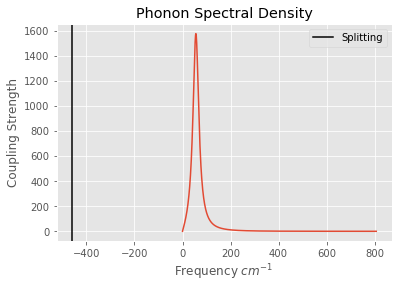

w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 3 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  2261.80044992  ** Took: 0.0473761558533s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 4 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  21.4720006027  ** Took: 0.0843670368195s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 5 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  12.6460436831  ** Took: 0.107578039169s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 6 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  8.43139290371  ** Took: 0.130636930466s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 7 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
	 ** Error:  5.97814285807  ** Took: 0.183845043182s**
w_RC= 57.6107142857  TLS splitting = 806.55

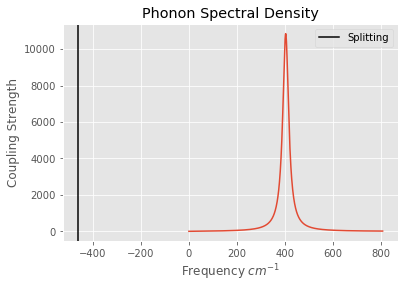

w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 3 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  2261.6893481  ** Took: 0.0487420558929s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 4 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  22.8904944179  ** Took: 0.0640270709991s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 5 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  15.7219600486  ** Took: 0.096556186676s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 6 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  10.3792490829  ** Took: 0.143913030624s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 7 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
	 ** Error:  6.8993843002  ** Took: 0.164035081863s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.011839683324

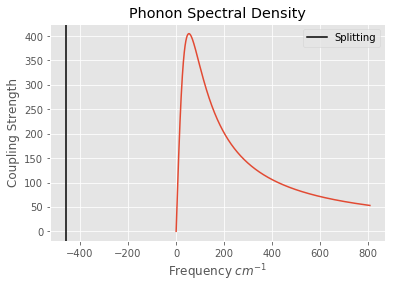

w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 3 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  2251.2225347  ** Took: 0.0620920658112s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 4 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  3.52865857276  ** Took: 0.0982210636139s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 5 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  1.69743172639  ** Took: 0.164844036102s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 6 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  0.757290633131  ** Took: 0.34219789505s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 7 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283
	 ** Error:  0.289945315983  ** Took: 0.416749000549s**
w_RC= 806.55  TLS splitting = 806.55 RC-res

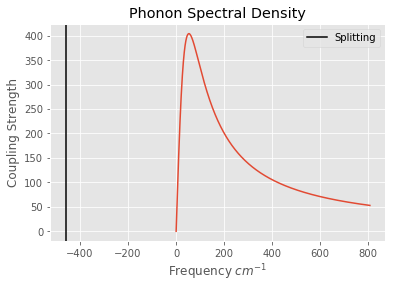

w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 3 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  2251.91747907  ** Took: 0.109745025635s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 4 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  4.14497569796  ** Took: 0.188554048538s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 5 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  2.1607994971  ** Took: 0.303818225861s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 6 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  1.04259315267  ** Took: 0.555399179459s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.63301186842  N= 7 TLS-RC coupling= 1238.04623444 Gamma_RC=  27616.5383137
	 ** Error:  0.382326082438  ** Took: 0.791372060776s**
w_RC= 1209.825  TLS splitting = 806

In [47]:

def integers(ni = 2, step=1):
    i = ni
    while True:
        i+=step
        yield i


def convergence_checker(alpha_prop, w0_prop, Gamma_, overdamped=False, threshold=10E-8):
    N_gen = integers()
    last_rc_sol = np.array([1])
    current_rc_sol = np.array([3])
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.axvline(eps-shift, label='Splitting',color='k')
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    while sum(abs(last_rc_sol - current_rc_sol)**2) >threshold:
        
        N = N_gen.next()
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects_wc = [G*G.dag(), E*G.dag()]
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, N)
        DATA_sc =  np.array(mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1])
        tf = time.time()
        last_rc_sol = np.array(current_rc_sol)
        current_rc_sol =  DATA_sc
        print '\t ** Error: ', sum(abs(
                last_rc_sol - current_rc_sol)**2), " ** Took: {}s**".format(tf-ti)

convergence_checker(1., 1./14., 30., threshold=10E-6)
convergence_checker(1., 1./2, 30., threshold=10E-6)

convergence_checker(1., 1., 0, overdamped=True, threshold=10E-6)
convergence_checker(1., 1.5, 0, overdamped=True, threshold=10E-6)

Underdamped:
- $\alpha=\epsilon$, $\omega_0=\epsilon/14, \Gamma=30cm^{-1}$ : converges at N=27 in 2.73s
- $\alpha=\epsilon$, $\omega_0=\epsilon/2, \Gamma=30cm^{-1}$ : converges at N=23 in 2.40s

Overdamped:
- $\alpha=\epsilon$, $\omega_0=1.5\epsilon, \Gamma=12274cm^{-1}$ : converges at N=16 in 6.6s
- $\alpha=\epsilon$, $\omega_0=2\epsilon, \Gamma=27617cm^{-1}$ : converges at N=15 in 9.17s

where $\Gamma$ is the width of the Lorentzian spectral density.

## Comparison to exact solution

How well does the RC theory agree with exact?
- w_0 dependence
- alpha dependence

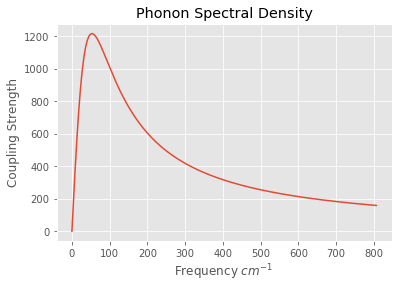

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 4.0628118515 seconds.
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 17 TLS-RC coupling= 175.086177559 Gamma_RC=  12274.0170283


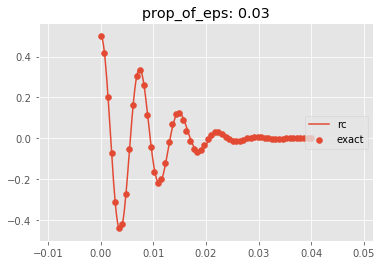

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 26.4374699593 seconds.
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 17 TLS-RC coupling= 725.428892213 Gamma_RC=  12274.0170283


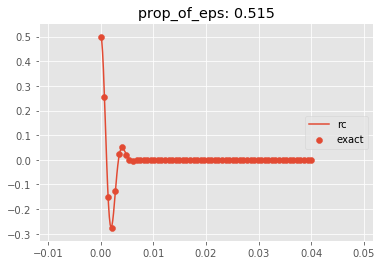

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 32.3640139103 seconds.
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.42200791228  N= 17 TLS-RC coupling= 1010.86051745 Gamma_RC=  12274.0170283


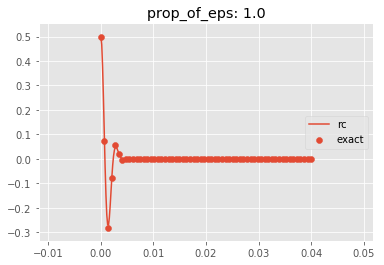

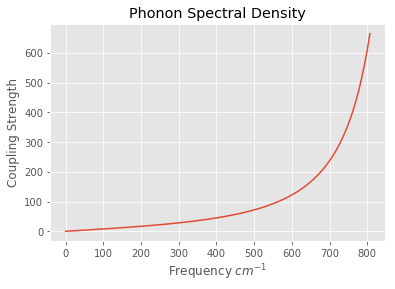

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 4.78558897972 seconds.
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 0.00493320138528  N= 23 TLS-RC coupling= 191.797297913 Gamma_RC=  30


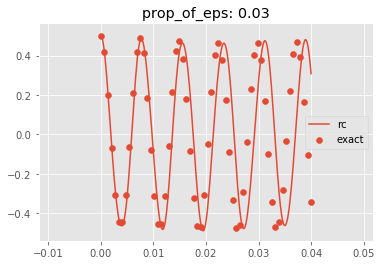

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 9.66169714928 seconds.
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 0.00493320138528  N= 23 TLS-RC coupling= 794.667536262 Gamma_RC=  30


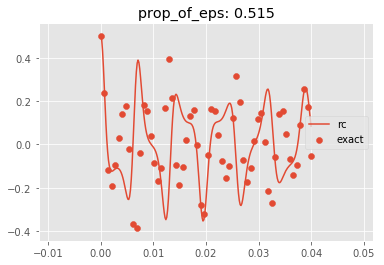

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 15.9188849926 seconds.
w_RC= 967.86  TLS splitting = 806.55 RC-res. bath coupling= 0.00493320138528  N= 23 TLS-RC coupling= 1107.3422158 Gamma_RC=  30


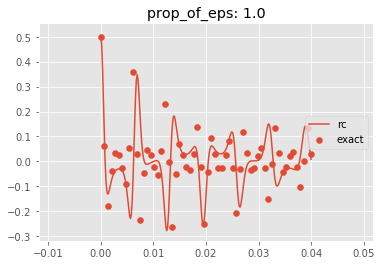

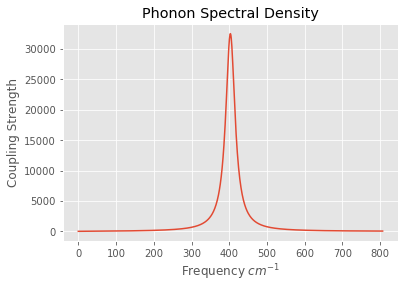

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 3.04883313179 seconds.
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 23 TLS-RC coupling= 123.804623444 Gamma_RC=  30


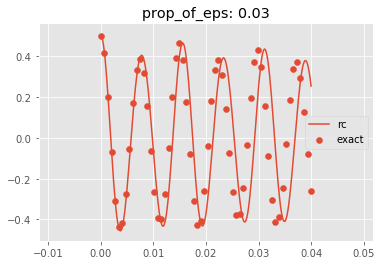

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 6.1670999527 seconds.
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 23 TLS-RC coupling= 512.955688953 Gamma_RC=  30


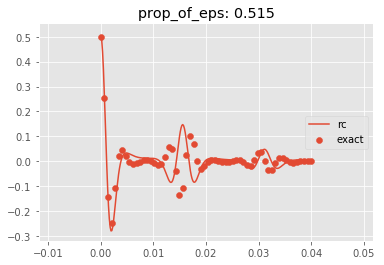

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 5.04882693291 seconds.
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 23 TLS-RC coupling= 714.786326724 Gamma_RC=  30


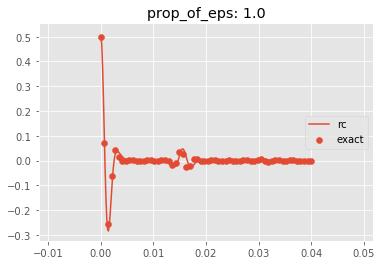

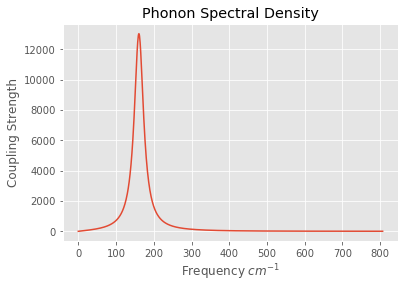

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 1.6619951725 seconds.
w_RC= 161.31  TLS splitting = 806.55 RC-res. bath coupling= 0.0295992083117  N= 27 TLS-RC coupling= 78.3009189886 Gamma_RC=  30


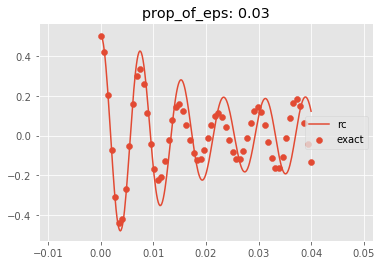

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 3.53192210197 seconds.
w_RC= 161.31  TLS splitting = 806.55 RC-res. bath coupling= 0.0295992083117  N= 27 TLS-RC coupling= 324.421663166 Gamma_RC=  30


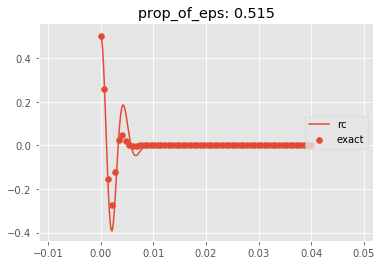

Exact solution 66.667 percent finished
Exact dynamics calculated
Exact solution took 3.80755996704 seconds.
w_RC= 161.31  TLS splitting = 806.55 RC-res. bath coupling= 0.0295992083117  N= 27 TLS-RC coupling= 452.070566559 Gamma_RC=  30


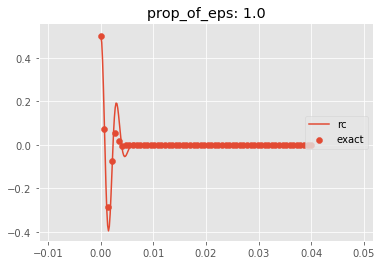

In [57]:

def exact_comparison_alpha(w0_prop, Gamma_, N=3, overdamped=False):
    timelist_exact = np.linspace(0, 0.04, 60)
    timelist = np.linspace(0, 0.04, 250)
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    w = np.linspace(0., eps, 1000)
    plt.figure()
    plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    plt.ylabel("Coupling Strength")
    plt.xlabel(r"Frequency $cm^{-1}$")
    plt.title("Phonon Spectral Density")
    plt.legend()
    plt.show()
    
    exact_sol = []
    rc_sol = []
    prop_of_eps = np.linspace(0.03,1,3)
    for prop in prop_of_eps:
        # how well
        alpha = prop*eps
        shift = 0. #0.5*np.pi*alpha*0.25
        ti = time.time()
        rho_01 = np.array(exact.exact_dynamics(eps, alpha, wc, 
                                               w0, Gamma_, beta, initial_sys, 
                                               timelist_exact, overdamped=overdamped))
        print "Exact dynamics calculated"
        print "Exact solution took {} seconds.".format(time.time()-ti)
        expects = [tensor(G*G.dag(), qeye(N)), tensor(E*G.dag(), qeye(N)), 
               tensor(E*E.dag(), qeye(N)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(N).dag()+destroy(N))]
        rho_0 = tensor(initial_sys, thermal_dm(N, n_RC))
        #DATA_wc = mesolve(H_S, initial_sys, timelist, [L_wc], expects_wc, progress_bar=True)
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma_, 
                                                                       w0, alpha, N)
        #print H_RC.eigenenergies()
        #print eps-0.5*np.pi*alpha, eps+w0, eps-0.5*np.pi*alpha+w0
        DATA_sc = mesolve(H_RC, rho_0, timelist, [L_RC], expects).expect[1].real
        #exact_sol.append(rho_01.real)
        #rc_sol.append(DATA_sc.real)
        plt.figure()
        plt.title("prop_of_eps: {}".format(prop))
        plt.scatter(timelist_exact, rho_01, label="exact")
        plt.plot(timelist, DATA_sc, label="rc")
        # Everything is oscillating at the shifted frequency
        #plt.plot(timelist, 0.5*np.exp((-50.-1j*(eps-shift))*timelist))  
        plt.legend(loc='right')
        plt.show()
        
exact_comparison_alpha(1., 0, N=17, overdamped=True)
exact_comparison_alpha(1.2, 30, N=23, overdamped=False)
exact_comparison_alpha(1./2., 30, N=23, overdamped=False)
exact_comparison_alpha(1./5., 30, N=27, overdamped=False)
#

#exact_comparison_alpha(1., 0., N=16, overdamped=True)
#exact_comparison_alpha(2., 0., N=15, overdamped=True)

So we can see that for broad overdamped environments the RC method works extremely well, however for more structured environments it doesn't match the exact solution.

## Convergence of optical driving code

Now we will check steadystate convergence with optical driving also

In [ ]:
w0 = eps*1.1
wc = 52.
Gamma = (w0**2)/wc
L_1, H_1, _, _, _, _, _= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, eps*0.5, 10) # E_e >0
L_2, H_2, _, _, _, _, _= RC.RC_function_UD(sigma, eps, T_ph, Gamma, w0, eps*0.8, 10) # E_e <0


def eigstate_calc_and_mag_sort(H, sort=True):
    # Helper function to calculate the eigenstates and sort
    # in order of eigvalue magnitude
    evals, evecs = H.eigenstates()
    if sort:
        evals, evecs = zip(*sorted(list(zip(evals, evecs)), key=lambda x: abs(x[0])))
    else:
        pass
    return np.array(evals), np.array(evecs)

print eigstate_calc_and_mag_sort(H_2, sort=False)

w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 3 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0398209095001 seconds.
It took  0.0362219810486  seconds to build the Non-secular RWA Liouvillian
It took  0.00285696983337  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.161510944366s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 4 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0711901187897 seconds.
It took  0.0600318908691  seconds to build the Non-secular RWA Liouvillian
It took  0.00261497497559  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.202716112137s**
w_RC= 57.6107142857  TLS splitting = 806.55 RC-res. bath coupling= 0.0828777832727  N= 5 TLS-RC coupling= 270.163837294 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0928251743317 seconds.
It took  

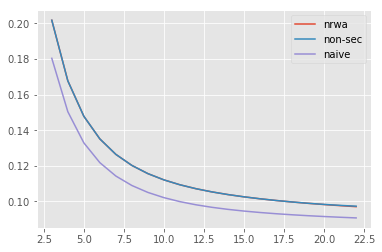

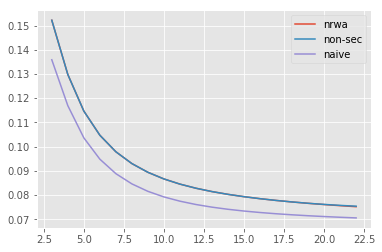

w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 3 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.0442209243774 seconds.
It took  0.0439331531525  seconds to build the Non-secular RWA Liouvillian
It took  0.00325608253479  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.169528961182s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 4 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.109290838242 seconds.
It took  0.134069919586  seconds to build the Non-secular RWA Liouvillian
It took  0.00518918037415  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.449654102325s**
w_RC= 403.275  TLS splitting = 806.55 RC-res. bath coupling= 0.0118396833247  N= 5 TLS-RC coupling= 714.786326724 Gamma_RC=  30.0
Calculating non-RWA Liouvilliian took 0.208013772964 seconds.
It took  0.0983700752258  seco

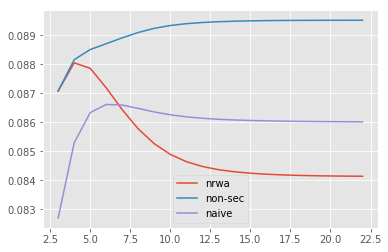

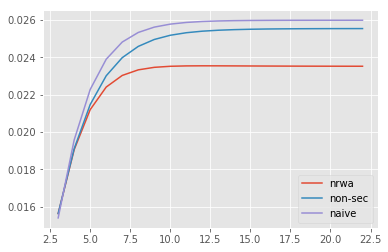

w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.46858498751  N= 3 TLS-RC coupling= 1010.86051745 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.0800268650055 seconds.
It took  0.0795102119446  seconds to build the Non-secular RWA Liouvillian
It took  0.00671792030334  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.282648086548s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.46858498751  N= 4 TLS-RC coupling= 1010.86051745 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.0810759067535 seconds.
It took  0.0818660259247  seconds to build the Non-secular RWA Liouvillian
It took  0.00348305702209  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.322741985321s**
w_RC= 806.55  TLS splitting = 806.55 RC-res. bath coupling= 2.46858498751  N= 5 TLS-RC coupling= 1010.86051745 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.167079925537 seconds.
It took  0

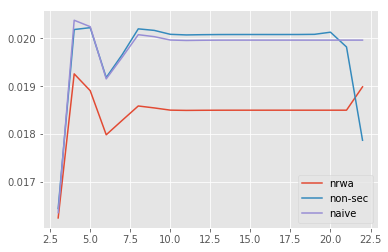

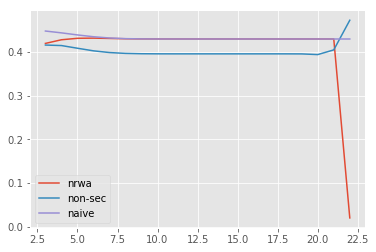

w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.70287748127  N= 3 TLS-RC coupling= 1238.04623444 Gamma_RC=  28147.6255889
Calculating non-RWA Liouvilliian took 0.0327470302582 seconds.
It took  0.0333399772644  seconds to build the Non-secular RWA Liouvillian
It took  0.00293493270874  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.129392147064s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.70287748127  N= 4 TLS-RC coupling= 1238.04623444 Gamma_RC=  28147.6255889
Calculating non-RWA Liouvilliian took 0.0649390220642 seconds.
It took  0.0604650974274  seconds to build the Non-secular RWA Liouvillian
It took  0.00257802009583  seconds to build the electronic-Lindblad Liouvillian
 ** Steady states took: 0.188793182373s**
w_RC= 1209.825  TLS splitting = 806.55 RC-res. bath coupling= 3.70287748127  N= 5 TLS-RC coupling= 1238.04623444 Gamma_RC=  28147.6255889
Calculating non-RWA Liouvilliian took 0.0960590839386 seconds.
It 

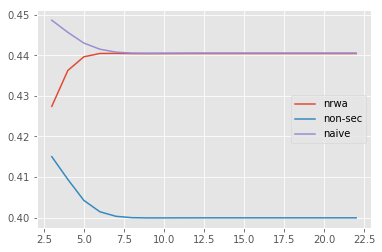

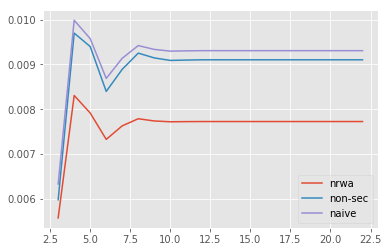

In [89]:

def driving_convergence_checker(alpha_prop, w0_prop, Gamma_, overdamped=False):
    e0_population = [[],[],[]]
    g1_population = [[],[],[]]
    labels = ['nrwa', 'non-sec', 'naive']
    alpha_ph = eps*alpha_prop
    shift = 0.5*np.pi*alpha_ph
    w0 = eps*w0_prop
    if overdamped:
        Gamma_ = (w0**2)/wc
    #w = np.linspace(0., eps, 1000)
    #plt.figure()
    #plt.plot(w, J_underdamped(w, alpha_ph, Gamma_, w0))
    #plt.axvline(eps-shift, label='Splitting',color='k')
    #plt.ylabel("Coupling Strength")
    #plt.xlabel(r"Frequency $cm^{-1}$")
    #plt.title("Phonon Spectral Density")
    #plt.legend()
    #plt.show()
    N_values = range(3,23)
    for n in N_values:
        rho_0 = tensor(initial_sys, thermal_dm(n, n_RC))
        #print (rho_0*tensor(qeye(2), destroy(N).dag()*destroy(N))).tr()

        # Expectation values and time increments needed to calculate the dynamics
        expects = [tensor(G*G.dag(), qeye(n)), tensor(E*G.dag(), qeye(n)), 
               tensor(E*E.dag(), qeye(n)), tensor(qeye(2), destroy(N).dag()*destroy(N)), 
               tensor(qeye(2), destroy(n).dag()+destroy(n))]
        ti = time.time()
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma_1= RC.RC_function_UD(
                                                    sigma, eps, T_ph, Gamma_, 
                                                    w0, alpha_ph, n)
        evals, states = eigstate_calc_and_mag_sort(H_RC, sort=False)
        
        L= [EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, 6000, J=J_EM), 
            EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, 6000, J=J_EM),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, 6000, J=J_EM)]
        
        for j, L_EM in enumerate(L):
            state = states[1]
            e0_population[j].append(steadystate(H_RC, [L_RC+L_EM]).matrix_element(
                                                                state.dag(), state))
            state = states[2]
            g1_population[j].append(steadystate(H_RC, [L_RC+L_EM]).matrix_element(
                                                                state.dag(), state))
        tf = time.time()
        print " ** Steady states took: {}s**".format(tf-ti)
    plt.figure()
    for i in range(len(e0_population)):
        plt.plot(N_values, e0_population[i], label=labels[i])
        plt.legend()
    plt.figure()
    for i in range(len(g1_population)):
        plt.plot(N_values, g1_population[i], label=labels[i])
        plt.legend()
    plt.show()
driving_convergence_checker(1., 1./14., 30.)
driving_convergence_checker(1., 1./2, 30.)

driving_convergence_checker(1., 1., 0, overdamped=True)
driving_convergence_checker(1., 1.5, 0, overdamped=True)

Now we will look at decay rates at short times and $T_{EM}=0$ from the $|e,0\rangle \to |g,k\rangle$ states.

w_RC= 887.205  TLS splitting = 806.55 RC-res. bath coupling= 2.71544348627  N= 17 TLS-RC coupling= 33.5264505177 Gamma_RC=  15137.1675389
Calculating non-RWA Liouvilliian took 0.668628931046 seconds.
It took  0.858992099762  seconds to build the Non-secular RWA Liouvillian
It took  0.00274395942688  seconds to build the electronic-Lindblad Liouvillian
w_RC= 887.205  TLS splitting = 806.55 RC-res. bath coupling= 2.71544348627  N= 17 TLS-RC coupling= 433.977279174 Gamma_RC=  15137.1675389
Calculating non-RWA Liouvilliian took 0.674379825592 seconds.
It took  0.933110952377  seconds to build the Non-secular RWA Liouvillian
It took  0.00277781486511  seconds to build the electronic-Lindblad Liouvillian
w_RC= 887.205  TLS splitting = 806.55 RC-res. bath coupling= 2.71544348627  N= 17 TLS-RC coupling= 612.820148815 Gamma_RC=  15137.1675389
Calculating non-RWA Liouvilliian took 0.680236101151 seconds.
It took  0.939623117447  seconds to build the Non-secular RWA Liouvillian
It took  0.0027019

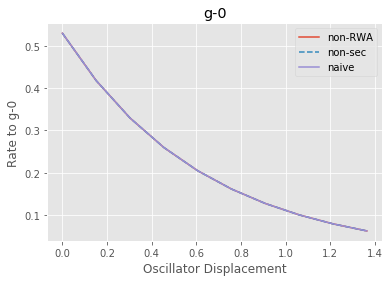

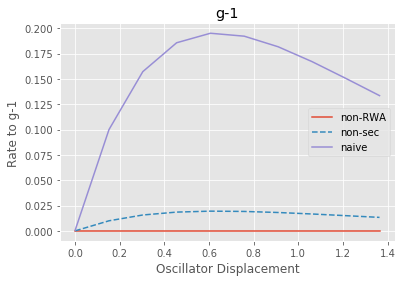

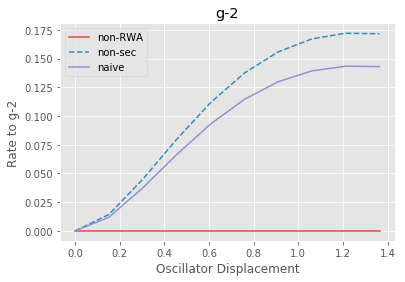

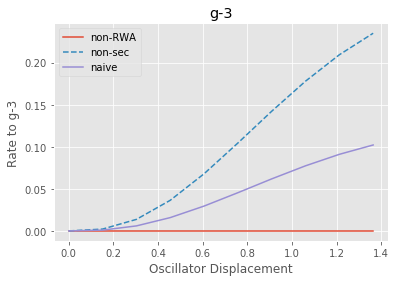

In [105]:
from qutip import vector_to_operator, operator_to_vector, basis




def decay_rate_plotter(eps, T_ph, w0, overdamped=True, nvib=3):
    alpha_ph = np.linspace(0.001,1.5,10)*eps
    displacements = alpha_ph/w0
    N = 17
    if overdamped:
        Gamma_ = w0**2/wc
    else:
        Gamma_ = 60.
    decay_wrt_alpha = [[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','g-3', 'g-4', 'g-5']
    
    for alpha_ in alpha_ph:
        L_RC, H, A_EM, A_nrwa, wRC, kappa, Gamma_1 = RC.RC_function_UD(sigma, eps, T_ph, Gamma_, w0, alpha_, N)
    # given some Liouvillian, find the instantaneous decay rates
    # from e-0 to the ground manifold eigenstates, for several
    # oscillator displacements
    # - need to find the first eigenstate in the excited manifold
        evals, states = eigstate_calc_and_mag_sort(H, sort=False)
        ground_list = []
        excited_list = []
        for i in range(N): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        excited_ket = states[excited_list[0]]
        
        #initial_ket = tensor(basis(2,1), basis(N,0))
        excited_rho = excited_ket*excited_ket.dag()
        
        L= [EM.L_non_rwa(H, A_nrwa, eps, Gamma_EM, 0, J=J_EM), 
            EM.L_nonsecular(H, A_EM, eps, Gamma_EM, 0, J=J_EM),
            EM.L_EM_lindblad(eps, A_EM, Gamma_EM, 0, J=J_EM)]
        for i_, L_EM in enumerate(L):
            decay_rates = [] # not really decay rates but population at short times
            for j in range(nvib):
                
                ground_ket = tensor(basis(2,0), basis(N,j))
                #print states[ground_list][j].dag()*target_ket
                #target_rho = operator_to_vector(target_ket*target_ket.dag())
                L_rho0_prod = vector_to_operator(L_EM*operator_to_vector(excited_ket*excited_ket.dag()))
                rate = L_rho0_prod.matrix_element(ground_ket.dag(), ground_ket)
                decay_rates.append(rate)
            """
            for ground_vibronic_ket in states[ground_list][0:nvib]:
                decay_rates.append(vector_to_operator(
                                    L_EM*operator_to_vector(init_rho)).matrix_element(
                                        ground_vibronic_ket.dag(),ground_vibronic_ket).real)
            """
            
            if len(decay_rates)!=nvib:
                print ground_list
            decay_wrt_alpha[i_].append(decay_rates)
    for level in range(nvib):
        plt.figure()
        plt.title(labels[level])
        plt.plot(displacements,np.array(decay_wrt_alpha[0]).T[level], label='non-RWA')
        plt.plot(displacements,np.array(decay_wrt_alpha[1]).T[level], label='non-sec', linestyle='dashed')
        plt.plot(displacements,np.array(decay_wrt_alpha[2]).T[level], label='naive')
        plt.legend()
        plt.xlabel('Oscillator Displacement')
        plt.ylabel('Rate to {}'.format(labels[level]))
    plt.show()
    return displacements, decay_wrt_alpha
    #for i, alpha in enumerate(alpha_ph):
    #    plt.plot(decay_wrt_alpha[i])

displacements, decay_wrt_alpha = decay_rate_plotter(eps, T_ph, eps*1.1, nvib=4)
#decay_rate_plotter(H_RC, L_ns)
#decay_rate_plotter(H_RC, L_n)

IT seems that:
- I can't see any decay rates from $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |e,0\rangle$. This could be due to the weird way I've calculated the matrix elements: by transforming to and from the superoperator formalism.
- Using my method of defining the rates $|e,0\rangle \to |g,k\rangle$ with $\langle g,k|L_{EM}\rho(0) |g,k\rangle$ I only see non-zero decay rates for non-RWA case for $n=0$. As alpha increases the decay to $|g,0\rangle$ decreases to zero (should be exponential overlap no?) by none of the other decay pathways open up as well. This would make it thermodynamically unstable, localising an population in the excited state (quantum zeno?).
- With $T_{EM}=0$ and $\rho(0)=|g, n\rangle$ there are rates going to the excited state for non-RWA. This doesn't make any sense as these states cannot be thermally populated.

Need to: 
- find which method is definitely correct. Speak to Ahsan.
- Calculate using Ahsan's derivation of the non-RWA master equation.
-

## Steady-state population of vibronic states: displacement dependence

In [101]:
def steadystate_coupling_dependence(prop_couplings, T_ph, eps, Gamma, w0, T_EM, 
                                    Gamma_EM, overdamped=True):
    w0 = eps*1.01
    plt.figure()
    N = 14
    G = ket([0])
    E = ket([1])
    sigma = G*E.dag() # Definition of a sigma_- operator.
    J = EM.J_minimal
    count = 1

    data_nrwa  = [[],[],[],[],[],[]]
    data_ns  = [[],[],[],[],[],[]]
    data_n  = [[],[],[],[],[],[]]
    labels = ['g-0',  'g-1', 'g-2','e-0','e-1', 'e-2'] 
    # This is true for specific Hamiltonian parameters
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for prop in prop_couplings:
        alpha_ph = prop*eps
        print count
        count+=1
        L_RC, H_RC, A_EM, A_nrwa, wRC, kappa, Gamma= RC.RC_function_UD(sigma, eps, 
                                                                       T_ph, Gamma, 
                                                                       w0, alpha_ph, N)
        evals, states = eigstate_calc_and_mag_sort(H_RC, sort=False)
        ground_list = []
        excited_list = []
        for i in range(20): #
            is_ground = sum(states[i])[0][0].real == 1.
            if is_ground:
                ground_list.append(i)
            else:
                excited_list.append(i)
        #print ground_list[0:3], excited_list[0:3]
        lowest_6 = states[ground_list[0:3] + excited_list[0:3]]
        #print len(excited_list), 'excited'
        # electromagnetic bath liouvillians
        L_nrwa = EM.L_non_rwa(H_RC, A_nrwa, eps, Gamma_EM, T_EM, J)
        L_ns = EM.L_nonsecular(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        #L_s = EM.L_vib_lindblad(H_RC, A_EM, eps, Gamma_EM, T_EM, J=J)
        L_n = EM.L_EM_lindblad(eps, A_EM, Gamma_EM, T_EM, J=J)
        for j, state in enumerate(lowest_6):
            method = 'iterative-lgmres'
            data_nrwa[j].append(steadystate(H_RC, [L_RC+L_nrwa]).matrix_element(
                                                                state.dag(), state))
            data_ns[j].append(steadystate(H_RC, [L_RC+L_ns]).matrix_element(
                                                                state.dag(), state))
            data_n[j].append(steadystate(H_RC, [L_RC+L_n]).matrix_element(
                                                                state.dag(), state))
    for i, lab in enumerate(labels):
        plt.figure()
        plt.title(lab)
        plt.plot(prop_couplings, data_nrwa[i], label='nrwa')
        plt.plot(prop_couplings, data_ns[i], label='ns')
        plt.plot(prop_couplings, data_n[i], label='n')
        plt.legend()
        plt.grid()
        plt.ylabel("Population")
        plt.xlabel(r"Phonon Coupling Strength: units of $\epsilon$")
    plt.show()

1
w_RC= 814.6155  TLS splitting = 806.55 RC-res. bath coupling= 2.44414355199  N= 14 TLS-RC coupling= 32.1256498082 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.611534118652 seconds.
It took  0.608576059341  seconds to build the Non-secular RWA Liouvillian
It took  0.00269198417664  seconds to build the electronic-Lindblad Liouvillian
2
w_RC= 814.6155  TLS splitting = 806.55 RC-res. bath coupling= 2.44414355199  N= 14 TLS-RC coupling= 170.750170895 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.602344036102 seconds.
It took  0.638022899628  seconds to build the Non-secular RWA Liouvillian
It took  0.00271701812744  seconds to build the electronic-Lindblad Liouvillian
3
w_RC= 814.6155  TLS splitting = 806.55 RC-res. bath coupling= 2.44414355199  N= 14 TLS-RC coupling= 239.330700801 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.598781824112 seconds.
It took  0.650859832764  seconds to build the Non-secular RWA Liouvillian
It took  

24
w_RC= 814.6155  TLS splitting = 806.55 RC-res. bath coupling= 2.44414355199  N= 14 TLS-RC coupling= 804.906216607 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.737061977386 seconds.
It took  0.68186378479  seconds to build the Non-secular RWA Liouvillian
It took  0.00268387794495  seconds to build the electronic-Lindblad Liouvillian
25
w_RC= 814.6155  TLS splitting = 806.55 RC-res. bath coupling= 2.44414355199  N= 14 TLS-RC coupling= 822.190720586 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.640353918076 seconds.
It took  0.686364173889  seconds to build the Non-secular RWA Liouvillian
It took  0.00277400016785  seconds to build the electronic-Lindblad Liouvillian
26
w_RC= 814.6155  TLS splitting = 806.55 RC-res. bath coupling= 2.44414355199  N= 14 TLS-RC coupling= 839.119267151 Gamma_RC=  12510.0558173
Calculating non-RWA Liouvilliian took 0.653352022171 seconds.
It took  0.712535142899  seconds to build the Non-secular RWA Liouvillian
It took

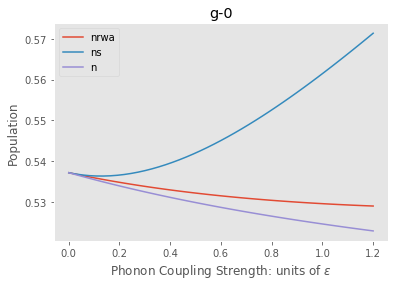

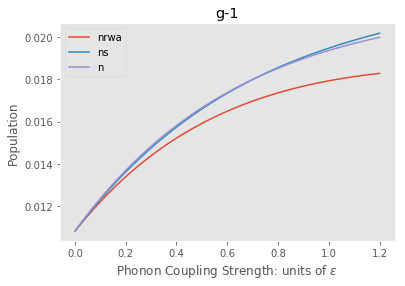

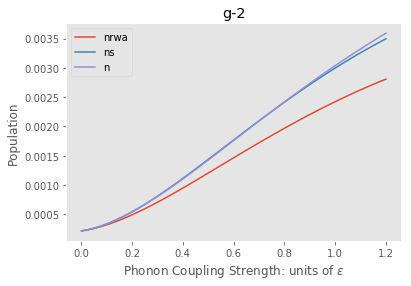

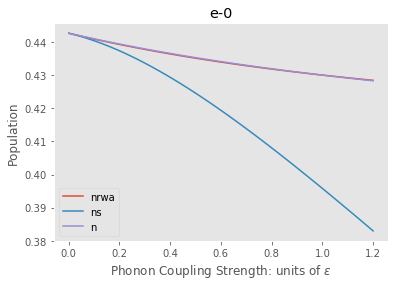

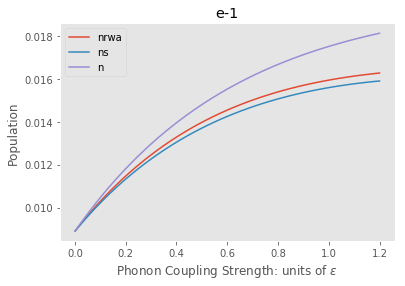

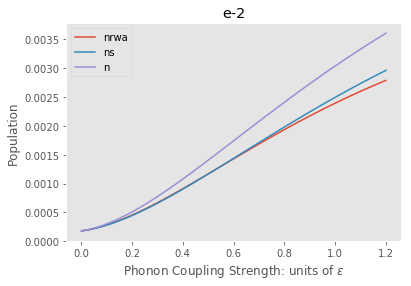

In [102]:
couplings = np.linspace(0.001,1.2,45)
steadystate_coupling_dependence(couplings, T_ph, eps, Gamma, w0, 
                                T_EM, Gamma_EM, overdamped=True)

## Dynamics of Vibronic States
Should be able to see the vibronic states being occupied, even if the rates are initially zero?